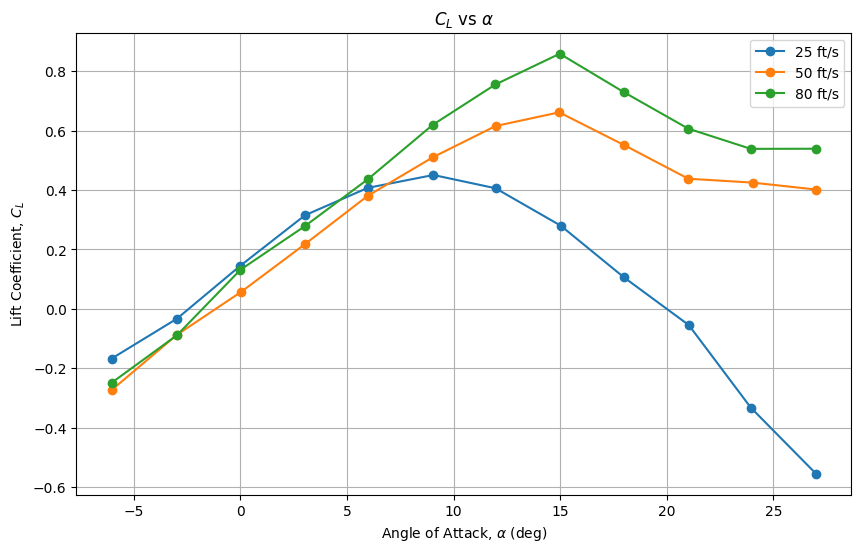

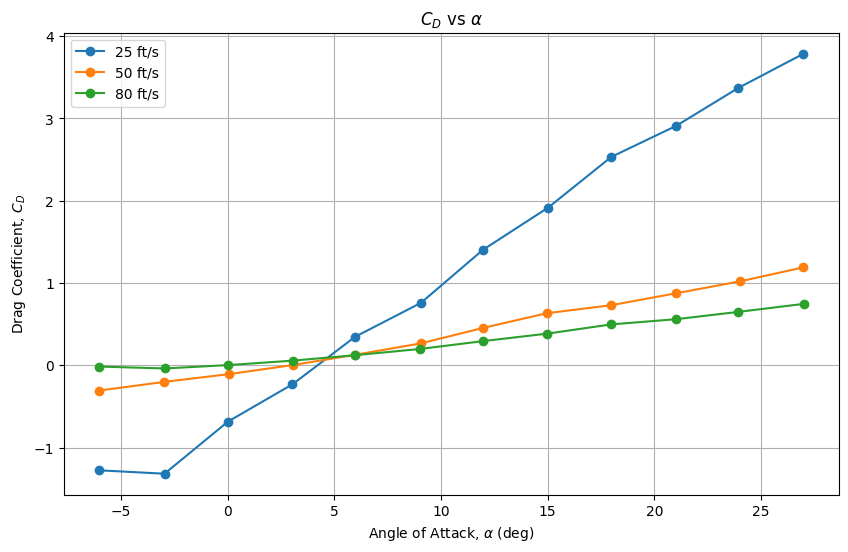

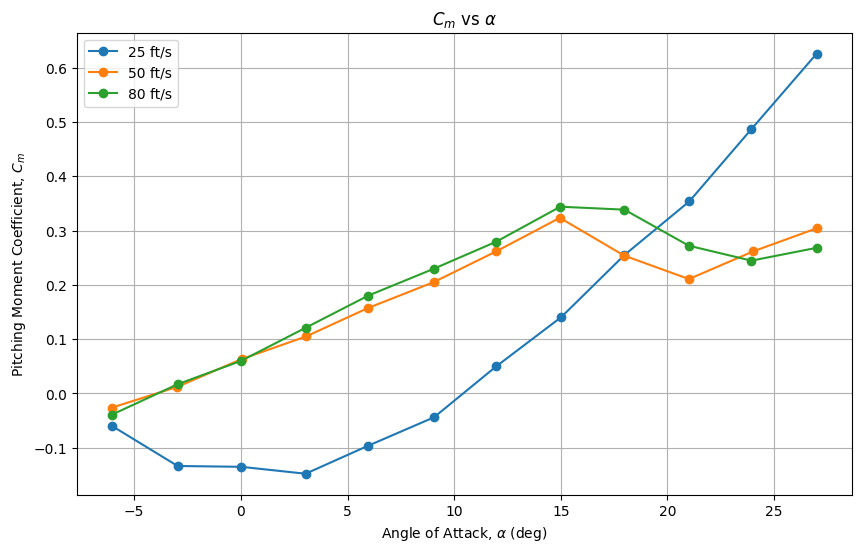

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


files = {
    '25 ft/s': 'design_lab_25.csv',
    '50 ft/s': 'design_lab_50.csv',
    '80 ft/s': 'design_lab_80.csv'
}

c_ref_in = 1.35       # Chord length (inches)
S_ref = 0.0498046875  # Wing Area (ft^2)

def process_data(filename):
    df = pd.read_csv(filename, skiprows=3)
    df.columns = df.columns.str.strip()
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['Angle of Attack', 'Normal Force'])
    
    alpha_rad = np.radians(df['Angle of Attack'])
    
    # wind-axis transformation
    df['Lift'] = df['Normal Force'] * np.cos(alpha_rad) - df['Axial Force'] * np.sin(alpha_rad)
    df['Drag'] = df['Normal Force'] * np.sin(alpha_rad) + df['Axial Force'] * np.cos(alpha_rad)

    # aerodynamic Coefficients
    df['q_psf'] = df['Corrected q'] * 144.0
    df['C_L'] = df['Lift'] / (df['q_psf'] * S_ref)
    df['C_D'] = df['Drag'] / (df['q_psf'] * S_ref)
    df['C_m'] = (df['Pitching Mom'] / (df['q_psf'] * S_ref * c_ref_in)) - (1.8 - 1.35) * df['C_L']/ c_ref_in
    
    return df


data = {}

for label, file in files.items():
    df = process_data(file)
    data[label] = df


def make_plot(ylabel, key, title, savefig_name):
    plt.figure(figsize=(10,6))
    for label, df in data.items():
        plt.plot(df['Angle of Attack'], df[key], marker='o', label=label)
    plt.grid(True)
    plt.xlabel(r"Angle of Attack, $\alpha$ (deg)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(savefig_name, dpi = 400)
    plt.show()

# coeff plots
make_plot(r"Lift Coefficient, $C_L$", "C_L", r"$C_L$ vs $\alpha$", "CL_vs_alpha.png")
make_plot(r"Drag Coefficient, $C_D$", "C_D", r"$C_D$ vs $\alpha$", "CD_vs_alpha.png")
make_plot(r"Pitching Moment Coefficient, $C_m$", "C_m", r"$C_m$ vs $\alpha$", "Cm_vs_alpha.png")


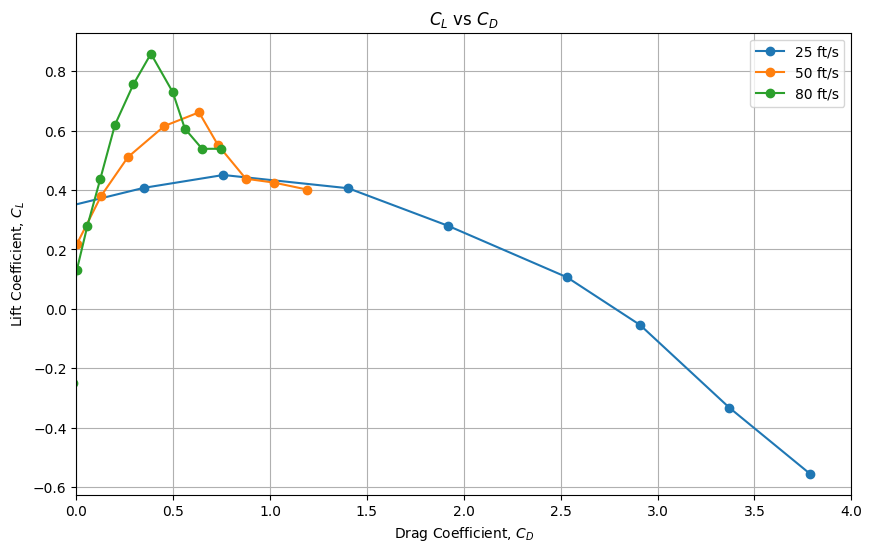

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

files = {
    '25 ft/s': 'design_lab_25.csv',
    '50 ft/s': 'design_lab_50.csv',
    '80 ft/s': 'design_lab_80.csv'
}

c_ref_in = 1.35       # Chord length (inches)
S_ref = 0.0498046875  # Wing Area (ft^2)

def process_data(filename):
    # Load and clean
    df = pd.read_csv(filename, skiprows=3)
    df.columns = df.columns.str.strip()
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['Angle of Attack', 'Normal Force'])
    
    # Convert to radians
    alpha_rad = np.radians(df['Angle of Attack'])
    
    # wind-axis transformation
    df['Lift'] = df['Normal Force'] * np.cos(alpha_rad) - df['Axial Force'] * np.sin(alpha_rad)
    df['Drag'] = df['Normal Force'] * np.sin(alpha_rad) + df['Axial Force'] * np.cos(alpha_rad)

    # aerodynamic Coefficients
    df['q_psf'] = df['Corrected q'] * 144.0       # convert psi → psf
    df['C_L'] = df['Lift'] / (df['q_psf'] * S_ref)
    df['C_D'] = df['Drag'] / (df['q_psf'] * S_ref)
    
    return df

data = {label: process_data(file) for label, file in files.items()}

# plot CL vs CD
plt.figure(figsize=(10,6))
for label, df in data.items():
    plt.plot(df['C_D'], df['C_L'], marker='o', label=label)

plt.grid(True)
plt.xlabel(r"Drag Coefficient, $C_D$")
plt.xlim(0, 4)
plt.ylabel(r"Lift Coefficient, $C_L$")
plt.title(r"$C_L$ vs $C_D$")
plt.legend()

# save figure
plt.savefig("CL_vs_CD.png", dpi=400)
plt.show()


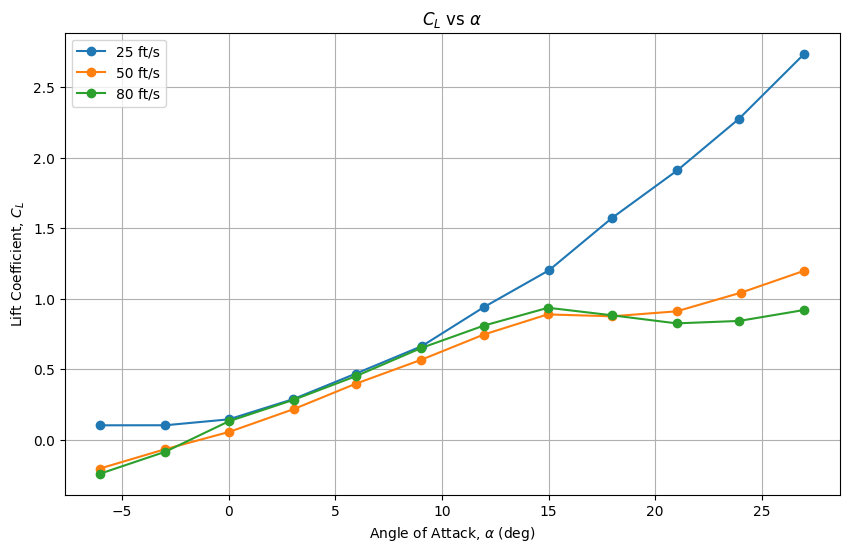

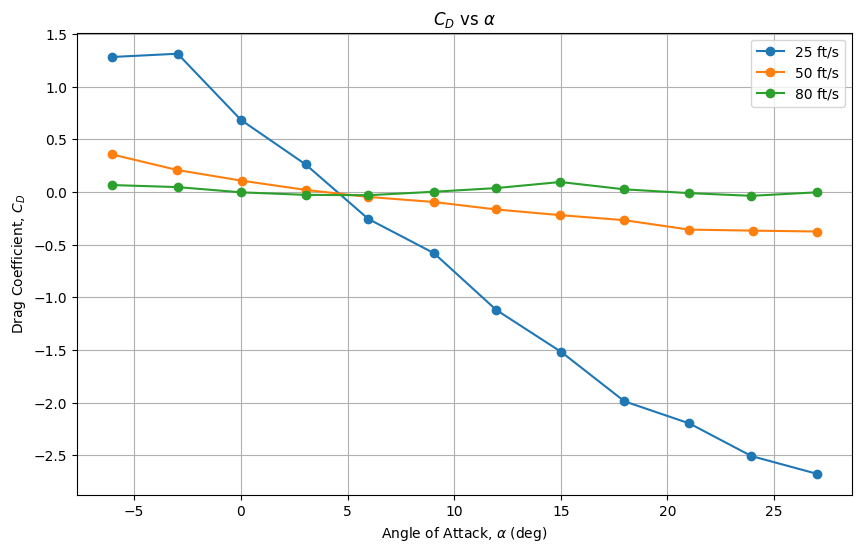

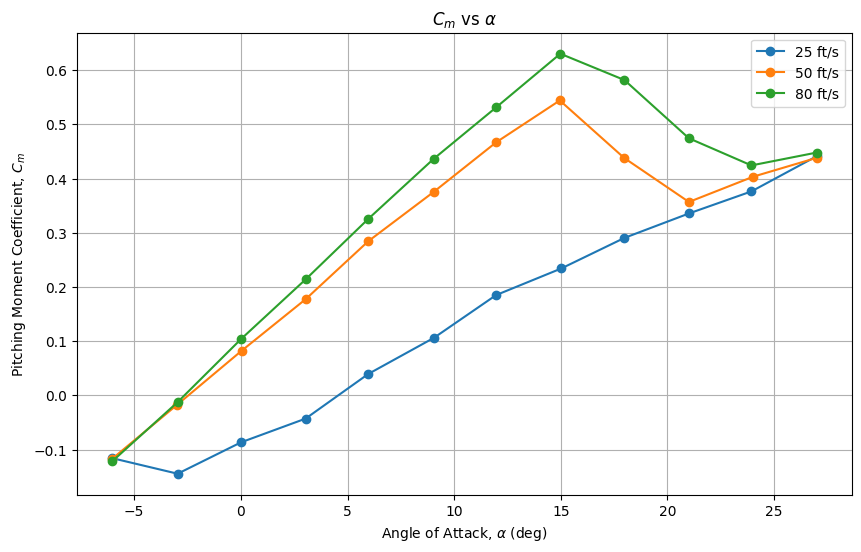

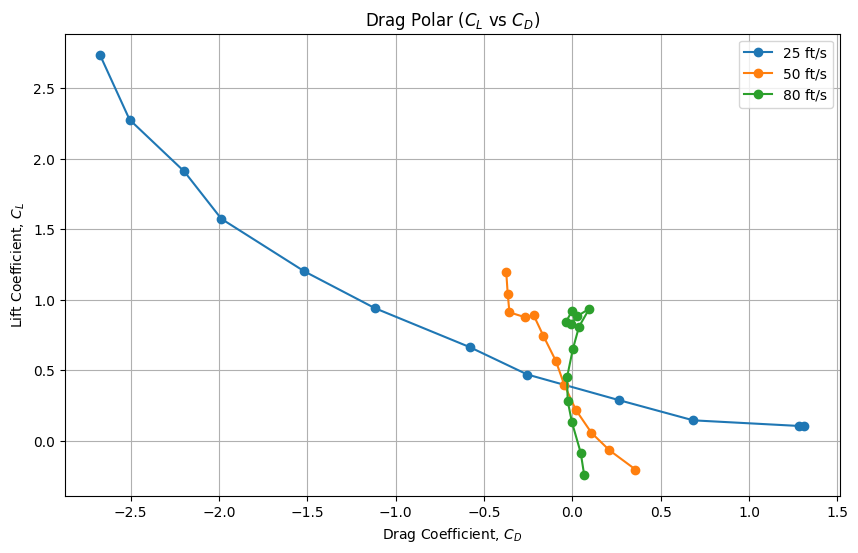

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

files = {
    '25 ft/s': 'design_lab_25.csv',
    '50 ft/s': 'design_lab_50.csv',
    '80 ft/s': 'design_lab_80.csv'
}

c_ref_in = 1.35       # Chord length (inches)
S_ref = 0.0498046875  # Wing Area (ft^2)

def process_data(filename):
    df = pd.read_csv(filename, skiprows=3)
    df.columns = df.columns.str.strip()
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['Angle of Attack', 'Normal Force'])
    
    alpha_rad = np.radians(df['Angle of Attack'])
    
    # --- CORRECTION START ---
    # In your data, Axial Force is negative at low angles, implying the sensor 
    # reads negative for forces pointing aft (Drag direction). 
    # We define a positive Axial Drag component by flipping the sign.
    Axial_Drag_Component = -df['Axial Force']
    
    # Wind-axis transformation
    # Lift is perpendicular to velocity vector
    df['Lift'] = df['Normal Force'] * np.cos(alpha_rad) - Axial_Drag_Component * np.sin(alpha_rad)
    
    # Drag is parallel to velocity vector
    df['Drag'] = df['Normal Force'] * np.sin(alpha_rad) + Axial_Drag_Component * np.cos(alpha_rad)
    # --- CORRECTION END ---

    # Aerodynamic Coefficients
    df['q_psf'] = df['Corrected q'] * 144.0  # Convert psi -> psf
    
    df['C_L'] = df['Lift'] / (df['q_psf'] * S_ref)
    df['C_D'] = df['Drag'] / (df['q_psf'] * S_ref)
    
    # C_m formula is dimensionally consistent because Moment is in-lbs and chord is inches
    df['C_m'] = df['Pitching Mom'] / (df['q_psf'] * S_ref * c_ref_in)
    
    return df


data = {}

for label, file in files.items():
    df = process_data(file)
    data[label] = df


def make_plot(ylabel, key, title, savefig_name):
    plt.figure(figsize=(10,6))
    for label, df in data.items():
        plt.plot(df['Angle of Attack'], df[key], marker='o', label=label)
    plt.grid(True)
    plt.xlabel(r"Angle of Attack, $\alpha$ (deg)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(savefig_name, dpi=400)
    plt.show()

# Coeff plots
make_plot(r"Lift Coefficient, $C_L$", "C_L", r"$C_L$ vs $\alpha$", "CL_vs_alpha.png")
make_plot(r"Drag Coefficient, $C_D$", "C_D", r"$C_D$ vs $\alpha$", "CD_vs_alpha.png")
make_plot(r"Pitching Moment Coefficient, $C_m$", "C_m", r"$C_m$ vs $\alpha$", "Cm_vs_alpha.png")

# Optional: Plot Polar (CL vs CD) to verify the fix
plt.figure(figsize=(10,6))
for label, df in data.items():
    plt.plot(df['C_D'], df['C_L'], marker='o', label=label)
plt.grid(True)
plt.xlabel(r"Drag Coefficient, $C_D$")
plt.ylabel(r"Lift Coefficient, $C_L$")
plt.title(r"Drag Polar ($C_L$ vs $C_D$)")
plt.legend()
plt.show()

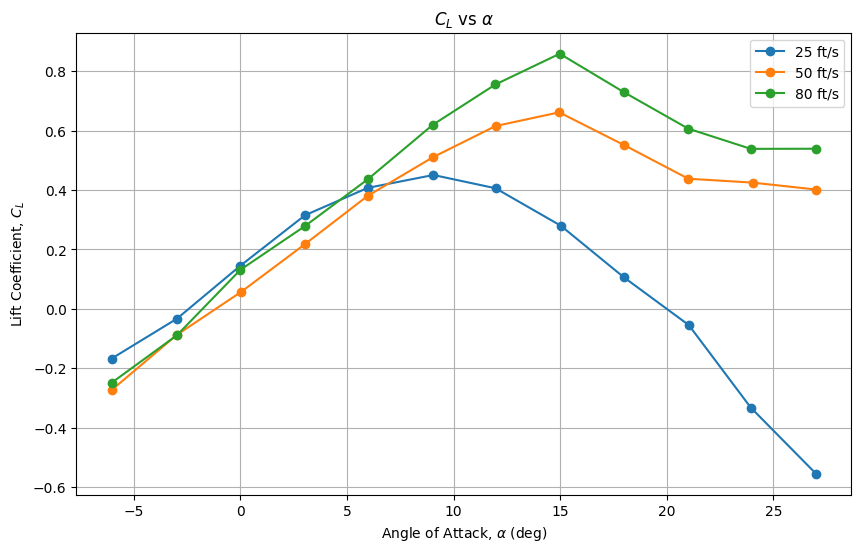

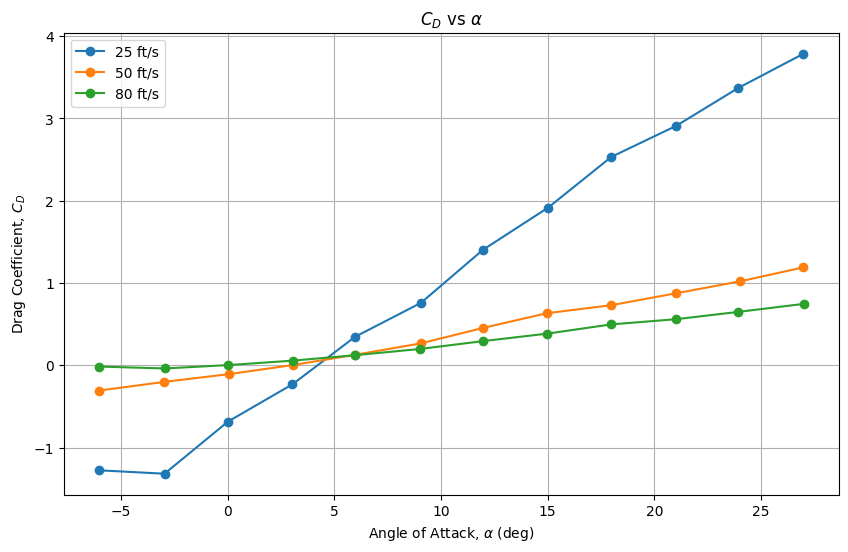

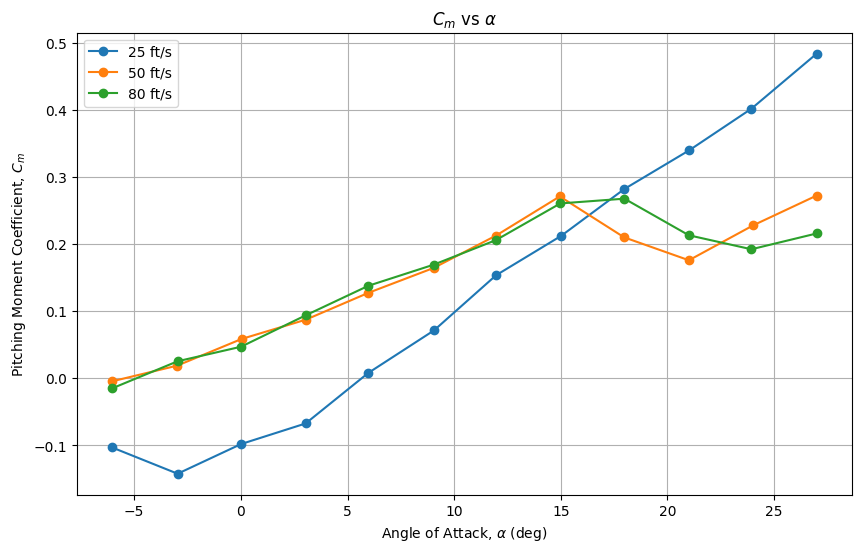

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


files = {
    '25 ft/s': 'design_lab_25.csv',
    '50 ft/s': 'design_lab_50.csv',
    '80 ft/s': 'design_lab_80.csv'
}


c_ref_in = 1.35        # chord length (inches)
S_ref = 0.0498046875   # wing area (ft^2)

# ---------------------------
# Neutral points (inches)
# ---------------------------
neutral_points = {
    '25 ft/s': 1.696,
    '50 ft/s': 1.243,
    '80 ft/s': 1.219
}


def process_data(filename, label):
    df = pd.read_csv(filename, skiprows=3)
    df.columns = df.columns.str.strip()
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['Angle of Attack', 'Normal Force'])
    
    alpha_rad = np.radians(df['Angle of Attack'])

    # Wind-axis transformation
    df['Lift'] = df['Normal Force'] * np.cos(alpha_rad) - df['Axial Force'] * np.sin(alpha_rad)
    df['Drag'] = df['Normal Force'] * np.sin(alpha_rad) + df['Axial Force'] * np.cos(alpha_rad)

    # Aero coefficients
    df['q_psf'] = df['Corrected q'] * 144.0
    df['C_L'] = df['Lift'] / (df['q_psf'] * S_ref)
    df['C_D'] = df['Drag'] / (df['q_psf'] * S_ref)

    # corrected pitching moment coefficient using neutral point
    x_ref = 1.8                       # reference moment point (inches)
    x_np = neutral_points[label]      # speed-specific neutral point (inches)
    dx = x_ref - x_np                 # shift between ref and NP (inches)

    df['C_m'] = (df['Pitching Mom'] / (df['q_psf'] * S_ref * c_ref_in)) - (dx / c_ref_in) * df['C_L']

    return df

data = {}
for label, file in files.items():
    df = process_data(file, label)
    data[label] = df


def make_plot(ylabel, key, title, savefig_name):
    plt.figure(figsize=(10,6))
    for label, df in data.items():
        plt.plot(df['Angle of Attack'], df[key], marker='o', label=label)
    plt.grid(True)
    plt.xlabel(r"Angle of Attack, $\alpha$ (deg)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(savefig_name, dpi=400)
    plt.show()

# generate plots
make_plot(r"Lift Coefficient, $C_L$", "C_L", r"$C_L$ vs $\alpha$", "CL_vs_alpha.png")
make_plot(r"Drag Coefficient, $C_D$", "C_D", r"$C_D$ vs $\alpha$", "CD_vs_alpha.png")
make_plot(r"Pitching Moment Coefficient, $C_m$", "C_m", r"$C_m$ vs $\alpha$", "Cm_vs_alpha.png")
